In [56]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.window import Window
from pyspark.sql.functions import col, asc, desc, max, avg, rank, lit
from pyspark.sql.functions import udf
from pyspark.sql.types import TimestampType, DateType
from datetime import datetime
from dateutil import parser
import numpy as np
# import pandas as pd
from time import time
import matplotlib.pyplot as plt
conf = SparkConf()
spark = SparkSession.builder.config(conf=conf).getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
sc.install_pypi_package("pandas==1.1.3") #Install pandas


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
sc.install_pypi_package("kiwisolver==1.2.0")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
sc.install_pypi_package("Pillow==8.0.1")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
sc.install_pypi_package("matplotlib==3.3.2")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
sc.list_packages()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version  
-------------------------- ---------
beautifulsoup4             4.9.1    
boto                       2.49.0   
certifi                    2022.9.24
click                      7.1.2    
cycler                     0.11.0   
jmespath                   0.10.0   
joblib                     0.15.1   
kiwisolver                 1.2.0    
lxml                       4.5.1    
matplotlib                 3.3.2    
mysqlclient                1.4.2    
nltk                       3.5      
nose                       1.3.4    
numpy                      1.16.5   
pandas                     1.1.3    
Pillow                     8.0.1    
pip                        9.0.1    
py-dateutil                2.2      
pyparsing                  3.0.9    
python-dateutil            2.8.2    
python37-sagemaker-pyspark 1.3.0    
pytz                       2020.1   
PyYAML                     5.3.1    
regex                      2020.6.8 
setuptools                 28.8.0   
s

# Intro

In [8]:
smog_df = spark.read.json("s3a://openaq-fetches/realtime/2022-10-28/*")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
smog_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- _corrupt_record: string (nullable = true)
 |-- attribution: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- url: string (nullable = true)
 |-- averagingPeriod: struct (nullable = true)
 |    |-- unit: string (nullable = true)
 |    |-- value: double (nullable = true)
 |-- city: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- latitude: double (nullable = true)
 |    |-- longitude: double (nullable = true)
 |-- country: string (nullable = true)
 |-- date: struct (nullable = true)
 |    |-- local: string (nullable = true)
 |    |-- raw: string (nullable = true)
 |    |-- utc: string (nullable = true)
 |-- location: string (nullable = true)
 |-- mobile: boolean (nullable = true)
 |-- parameter: string (nullable = true)
 |-- sourceName: string (nullable = true)
 |-- sourceType: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- value: double (nullable =

In [9]:
smog_df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

5326635

In [10]:
smog_df.select('parameter').distinct().toPandas()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  parameter
0      None
1        co
2      pm10
3       so2
4       no2
5        bc
6      pm25
7        o3

In [11]:
smog_df.select('country').distinct().toPandas()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    country
0        DZ
1        FI
2        MN
3        MX
4        CZ
..      ...
101      TH
102      MA
103      NO
104      CF
105      AF

[106 rows x 1 columns]

In [13]:
smog_df.filter(col('country')=='PL').select('city').distinct().toPandas()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

            city
0       Jarosław
1         Rybnik
2      Widuchowa
3         Ustroń
4           Łódź
..           ...
166   Krapkowice
167        Tychy
168  Dzierżoniów
169        Opole
170     Zielonka

[171 rows x 1 columns]

# Zad 1

Znajdź miasta w Polsce, w których średnie stężenie pyłu “pm25” było niższe niż maksymalne stężenie w Paryżu (w całym badanym okresie). Obliczenia wykonaj dla danych z kilku dni. Wyniki posortuj malejąco po stężeniu pm25.

In [9]:
smog_df = spark.read.json("s3a://openaq-fetches/realtime/2022-10-25/*")
smog_df1 = spark.read.json("s3a://openaq-fetches/realtime/2022-10-26/*")
smog_df2 = spark.read.json("s3a://openaq-fetches/realtime/2022-10-27/*")
smog_df3 = spark.read.json("s3a://openaq-fetches/realtime/2022-10-28/*")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
df_concat = smog_df.union(smog_df1).union(smog_df2).union(smog_df3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
df_concat = df_concat.filter(
    (col("date.utc") >= lit("2022-10-25T00:00:000Z")) & (col("date.utc") <  lit("2022-10-29T00:00:000Z"))
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
df_concat.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14108302

In [39]:
avg_pm_by_city = (
    df_concat
    .filter((col('country')=='PL') & (col('parameter') == 'pm25'))
    .groupby('city')
    .avg('value'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
max_val_paris = (
    df_concat
    .filter((col('country')=='FR') & (col('parameter') == 'pm25'))
    .groupby('city')
    .max('value')
    .filter(col('city') == 'Paris')
    .select('max(value)').collect()[0])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
print(max_val_paris[0])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

28.1

In [20]:
avg_pm_less_than_paris = avg_pm_by_city.filter(col('avg(value)') < max_val_paris[0])
avg_pm_less_than_paris.orderBy(avg_pm_less_than_paris["avg(value)"].desc()).show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+------------------+
|            city|        avg(value)|
+----------------+------------------+
|         Kłodzko|27.293114779582368|
|          Kalisz| 27.23912648825065|
|        Augustów| 27.19101382488479|
|          Kielce|26.022150289017333|
|       Włocławek|25.921333333333333|
|   Lwówek Śląski|25.559826709154112|
|        Żyrardów| 25.41918158567775|
|       Białystok| 25.15170187793428|
|    Starachowice|24.873788748564863|
|         Wschowa| 24.44555043683589|
|          Lębork| 24.32621637019232|
|           Toruń| 23.11911170928667|
|         Siedlce| 22.84991652754591|
|Rudnik nad Sanem|22.786045342960293|
|         Ostróda|22.565467591036416|
|        Warszawa| 22.49984465427962|
|             Ełk|22.469686837708828|
|       Szamotuły|22.190349123711336|
|        Racibórz|  22.0790989571263|
|     Kościerzyna| 21.98511827130853|
+----------------+------------------+
only showing top 20 rows

# Zad 2

Dla danych z wybranych kilku dni przedstaw w ujęciu godzinowym (wybierz czas UTC) najwyższe zanotowane stężenie pm10 w poszczególnych miastach z całego zbioru danych. Wyniki posortuj po rosnąco datach.

In [30]:
def get_date_and_hour(date):
    parsed = parser.isoparse(date["utc"])
    return parsed.replace(minute=0, second=0)

parse_datetime = udf(get_date_and_hour, TimestampType())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
(df_concat
 .select("city", "date", "parameter", "value")
 .na.drop()
 .withColumn("datetime", parse_datetime("date"))
 .where( (col("parameter") == "pm10"))
 .groupBy("datetime", "city")
 .agg(max("value").alias("max_pm10_value"))
 .orderBy("datetime").show(20))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+--------------------+--------------+
|           datetime|                city|max_pm10_value|
+-------------------+--------------------+--------------+
|2022-10-25 00:00:00|     Tasmania Region|          19.0|
|2022-10-25 00:00:00|        NEWFOUNDLAND|          63.0|
|2022-10-25 01:00:00|Banskobystrický kraj|        29.178|
|2022-10-25 01:00:00|            Lewisham|          11.0|
|2022-10-25 01:00:00|            SOMERSET|          13.0|
|2022-10-25 01:00:00|               Doubs|          11.4|
|2022-10-25 01:00:00|Cincinnati-Middle...|          26.0|
|2022-10-25 01:00:00|           Andacollo|          55.0|
|2022-10-25 01:00:00|            PONTOTOC|           3.0|
|2022-10-25 01:00:00|                Bury|          14.0|
|2022-10-25 01:00:00|               Łomża|          29.5|
|2022-10-25 01:00:00|              Gdańsk|       19.1945|
|2022-10-25 01:00:00|       French Guiana|          21.3|
|2022-10-25 01:00:00|          Ridderkerk|          12.3|
|2022-10-25 01

# Zad 3

Znajdź ranking miast w Europie pod względem średniego zanieczyszczenia liczonego dla N najwyższych pomiarów pod względem “pm25” dla danych z kilku dni. 

In [67]:
europe_countries = ['AD', 'AT', 'BA', 'BG', 'CH', 'CY', 'CZ', 'DE', 
                    'DK', 'DZ', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR',
                    'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'MD',
                    'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO',
                    'RS', 'SE', 'SI', 'SK', 'TR']

def get_n_most_polluted_cities(df_in,n):
    window = Window.partitionBy("city").orderBy("value")
    
    df = (df_in
    .select("city", "parameter", "value")
    .na.drop().filter((col("city").rlike("^[a-zA-Z]+$")))
    .filter(df_in.country.isin(europe_countries))
    .withColumn("rank", rank().over(window))
        )
    
    df_out = (
        df
        .select("city", "value")
        .where(col("rank") <= n)
        .groupBy("city")
        .agg(avg("value").alias('avg value'))
        .orderBy(desc('avg value'))
    )
    
    return df_out

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
get_n_most_polluted_cities(df_concat, 10).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+------------------+
|           city|         avg value|
+---------------+------------------+
|Zeppelinfjellet|           65.8125|
|          Kerry|              60.3|
|     Tustervatn| 35.41428571428571|
|        Lerwick|              34.0|
|        Lucerne|26.078066666666665|
|           Bern|25.495649999999998|
|         Valais|24.814966666666667|
|         Sandve|24.218181818181822|
|      Weybourne|              22.0|
|        Thurgau| 20.99573333333333|
|       Birkenes|             19.04|
|        Karpacz| 18.11307647058824|
|      Kronoberg|16.050000000000004|
|        Pleszew|           13.8137|
|      Zawiercie| 13.65632857142857|
|      Cambridge|              13.0|
|         Olkusz|12.493585714285715|
|    Prestebakke|12.214285714285717|
|           Vaud|11.868475000000002|
|         Mosina|11.377399999999998|
+---------------+------------------+
only showing top 20 rows

# Zadanie 4

Zwizualizuj na mapie średnie zanieczyszczenie w danym kraju dla wybranych kilku dni względem czasu (mapa + slider czasu albo zbiór klatek i animacja) dla wybranych państw.

In [20]:
def parse_date(date):
    parsed = parser.isoparse(date["utc"])
    return parsed.date()

parse_date_udf = udf(parse_date, DateType())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
import plotly.express as px
import plotly.figure_factory as ff

def obtain_country_heatmap(country):
    df = (
        df_concat
        .select("coordinates", "value", "date")
        .na.drop()
        .where(col("country") == country)
        .withColumn("date", parse_date_udf("date"))
    )
    df = (
        df
        .groupBy("coordinates", "date")
        .agg(avg("value").alias("avg_value"))
        .orderBy("date", "coordinates")
        .select("date", "coordinates.latitude", "coordinates.longitude", "avg_value")
    )
    return df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
# %%spark -o pdf

pdf = get_country_heatmap("PL")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

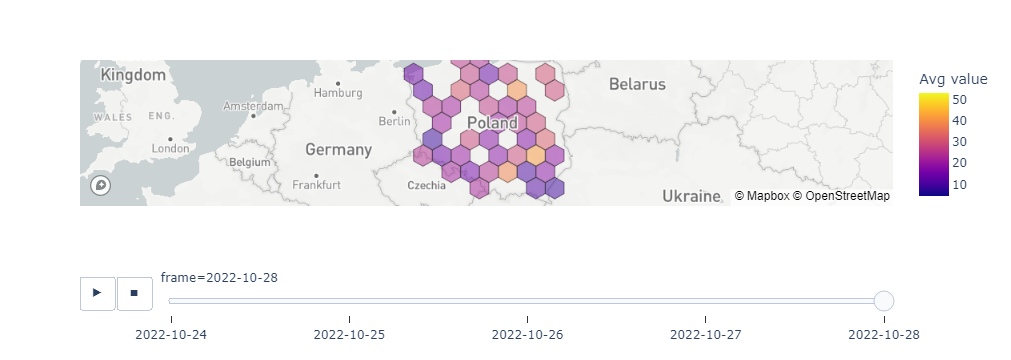

In [26]:
%%local


px.set_mapbox_access_token("pk.eyJ1Ijoib3Jlb3JlIiwiYSI6ImNrdndwNm13aTBhZzYyb2xjcng4dGdnNWEifQ.LADFJcYpNwTupseSVwA72g")
pdf = pdf.astype({"date": str})

fig = ff.create_hexbin_mapbox(
    data_frame=pdf,
    lat="latitude",
    lon="longitude",
    nx_hexagon=8, 
    opacity=0.5, 
    color="avg_value", 
    labels={"color": "Avg value"}, 
    min_count=1, 
    animation_frame="date",
    agg_func=np.mean
)

fig.show()

# Zadanie 5

Korzystanie z klastra dla dużych danych

a) Proszę wykonać zadanie 1 dla danych z całego miesiąca. Zmierzyć czas wykonania

b) Zwiększyć klaster do 2, 3, 4, 5, 6, 7 instancji workerów i zmierzyć czasy wykonania


c) Narysować wykresy czasu, przyspieszenia, efektywności oraz miarę Karpa-Flatta (time, speedup, efficiency)


In [43]:
smog_df = spark.read.json("s3a://openaq-fetches/realtime/2022-10*")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
smog_df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

138799005

In [49]:

start = time()

avg_pm_by_city_month = (
    smog_df.filter((col('country')=='PL') & (col('parameter') == 'pm25'))
    .groupby('city')
    .avg('value'))
    
max_val_paris_month = (
    smog_df.filter((col('country')=='FR') & (col('parameter') == 'pm25'))
    .groupby('city')
    .max('value')
    .filter(col('city') == 'Paris')
    .select('max(value)').collect()[0])
    
avg_pm_less_than_paris_month = avg_pm_by_city_month.filter(col('avg(value)') < max_val_paris_month[0])
avg_pm_less_than_paris_month.orderBy(avg_pm_less_than_paris_month["avg(value)"].desc()).show(20)
    
end = time()
print(end - start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+------------------+
|             city|        avg(value)|
+-----------------+------------------+
|          Pińczów|30.001756940399943|
|           Lublin|28.858843537414955|
|   Janów Lubelski|27.170338451895937|
|           Kalisz| 25.27465975800033|
|Kazimierza Wielka| 25.08366096866096|
|Nakło nad Notecią| 24.02336227308603|
|     Starachowice|23.568141517476565|
|           Otwock|22.608824456350447|
|           Sierpc| 22.52221874511032|
| Jastrzębie-Zdrój|22.220030214854862|
|         Racibórz|22.008686860647543|
|        Włocławek|  21.3809293487649|
|         Szczytno|21.294738453120388|
|        Szamotuły|21.246022338773553|
|          Kłodzko|21.170016063541805|
| Rudnik nad Sanem|20.870305199882846|
|        Legionowo|20.814169659654524|
|           Kielce|20.753340498710237|
|             Łask|20.669818597343223|
|    Lwówek Śląski|20.641329428202923|
+-----------------+------------------+
only showing top 20 rows

191.3525414466858

In [52]:
workers = np.arange(2, 8)
times = np.array([478.14635729789734, 378.85002613067627, 311.2718765735626, 260.486501455307, 238.63675475120544, 191.3525414466858])
speedups = times[0] / times
efficiencies = speedups / workers

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

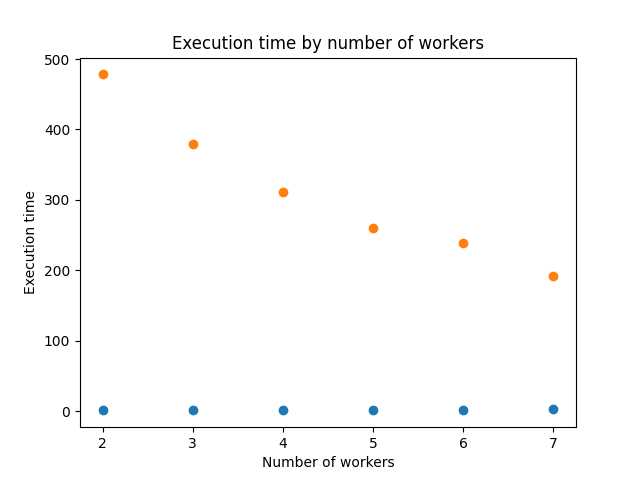

In [69]:
plt.scatter(workers, times)
plt.xlabel("Number of workers")
plt.ylabel("Execution time")
plt.title("Execution time by number of workers")
plt.show()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

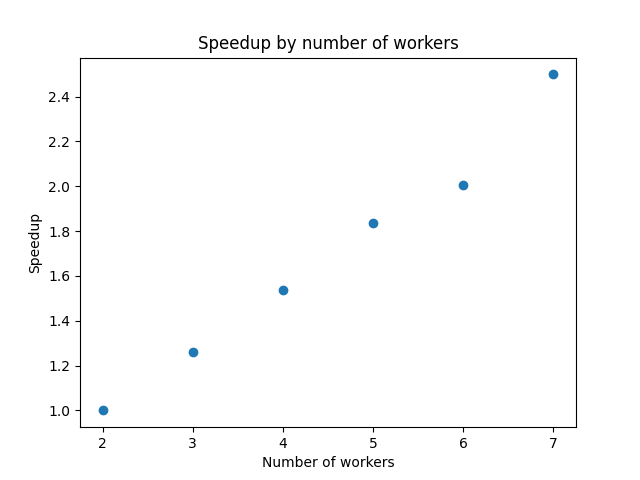

In [70]:
plt.clf()
plt.scatter(workers, speedups)
plt.xlabel("Number of workers")
plt.ylabel("Speedup")
plt.title("Speedup by number of workers")
plt.show()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

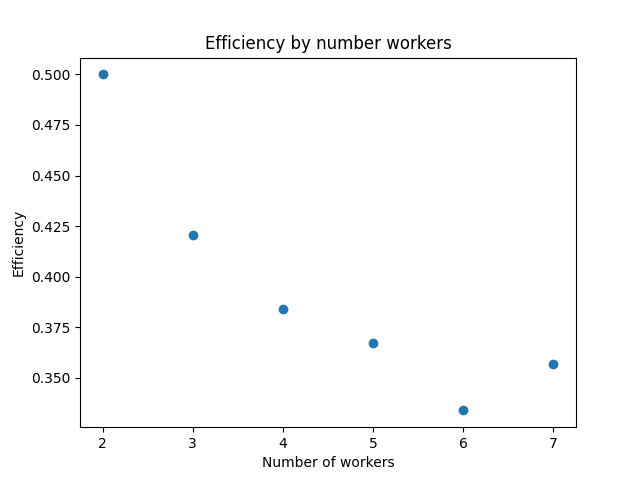

In [72]:
plt.clf()
plt.scatter(workers, efficiencies)
plt.xlabel("Number of workers")
plt.ylabel("Efficiency")
plt.title("Efficiency by number workers")
plt.show()
%matplot plt

# Zadanie 6 

Wykonaj przykładowe zapytanie dla danych z całego roku 2021. Załącz wybrane wykresy ze Spark UI (https://spark.apache.org/docs/latest/web-ui.html), np. DAG, diagram Gantta, informacje o rozmiarach danych.


In [78]:
smog_2021_df = spark.read.json("s3a://openaq-fetches/realtime/2021-*-*/*")
smog_2021_df = smog_2021_df.where(
    (col("date.utc") >= lit("2021-01-01T00:00:000Z")) & 
    (col("date.utc") <  lit("2022-01-01T00:00:000Z"))
)

df = (smog_2021_df
      .select('value','city')
      .filter(col('country') == 'PL')
      .groupby('city')
      .avg('value'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

![DAG Diagram](https://spark.apache.org/docs/latest/img/JobPageDetail2.png)

![Job Page Detail](https://spark.apache.org/docs/latest/img/JobPageDetail1.png)

![webui-structured-streaming-detail](https://spark.apache.org/docs/latest/img/webui-structured-streaming-detail.png)